In [1]:
import QNN as qnn
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

2024-01-09 04:27:39.852032: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 04:27:39.852045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 04:27:39.852554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs


In [3]:
def create_cat_state(alpha, size=10):
    """Create a cat state with given alpha and Hilbert space size."""
    cat_state = qt.coherent(size, alpha) + qt.coherent(size, -alpha)
    cat_state /= cat_state.norm()  # Normalize the state
    return cat_state

def wigner_log_negativity(cat_state, xvec, yvec):
    W = qt.wigner(cat_state, xvec, yvec)
    dx = xvec[1] - xvec[0]  # Assuming uniform spacing
    dy = yvec[1] - yvec[0]

    integral = np.sum(np.abs(W)) * dx * dy
    return np.log(integral)

# Parameters for the cat state and Wigner function
alpha = range(500)  # Coherent state amplitude
size = 10  # Hilbert space size
xvec = np.linspace(-np.pi, np.pi, 100)  # X-axis values for Wigner function
yvec = np.linspace(-np.pi, np.pi, 100)  # Y-axis values for Wigner function

# Create cat state and calculate its Wigner log negativity
def wig(alpha, size, xvec, yvec):
    WLN = []
    for i in alpha:
        cat_state = create_cat_state(i, size)
        log_neg = wigner_log_negativity(cat_state, xvec, yvec)
        WLN.append(log_neg)
    
    return WLN

W = wig(alpha, size, xvec, yvec)

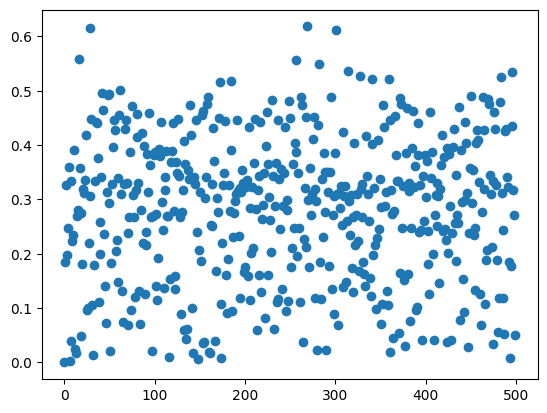

In [4]:
len(W)
plt.scatter(alpha, W)

In [2]:
X = np.linspace(-10, 10, 1000)
Y = X*np.sin(X)*np.cos(X)
Y_noisy = Y + 0.1*np.random.randn(1000)
Y_noisy = (Y_noisy - np.mean(Y_noisy))/np.std(Y_noisy)
X_data = X.astype(np.float32).reshape(-1, 1)
Y_data = Y_noisy.astype(np.float32).reshape(-1, 1)

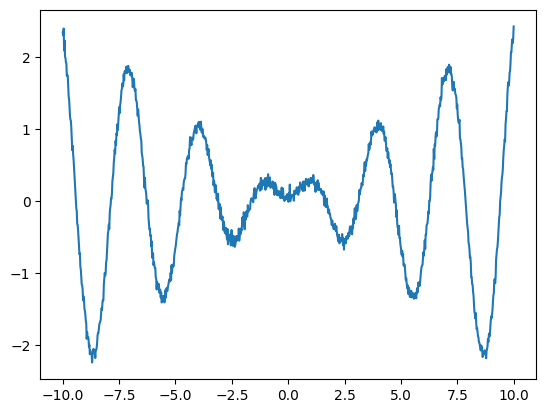

In [3]:
plt.plot(X, Y_noisy)

In [4]:
M, H = qnn.train_models(X_data, Y_data, cutoff_dim=5, configs=[(1, 2)], qmonitor = False, split = 0.1)

/scratch/Song/tfenv/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Training model with 1 layers for 2 epochs...


Epoch 2/2: 100%|██████████| 2/2 [00:06<00:00,  3.34s/it]

Total training time: 6.67 seconds
Training Complete.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 QuantumEncoding (QEncoder)  (None, 5, 1)              0         
                                                                 
 QuantumLayer_1 (QLayer)     (None, 5, 1)              6         
                                                                 
 QuantumDecoding (QDecoder)  (None,)                   0         
                                                                 
Total params: 6 (24.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


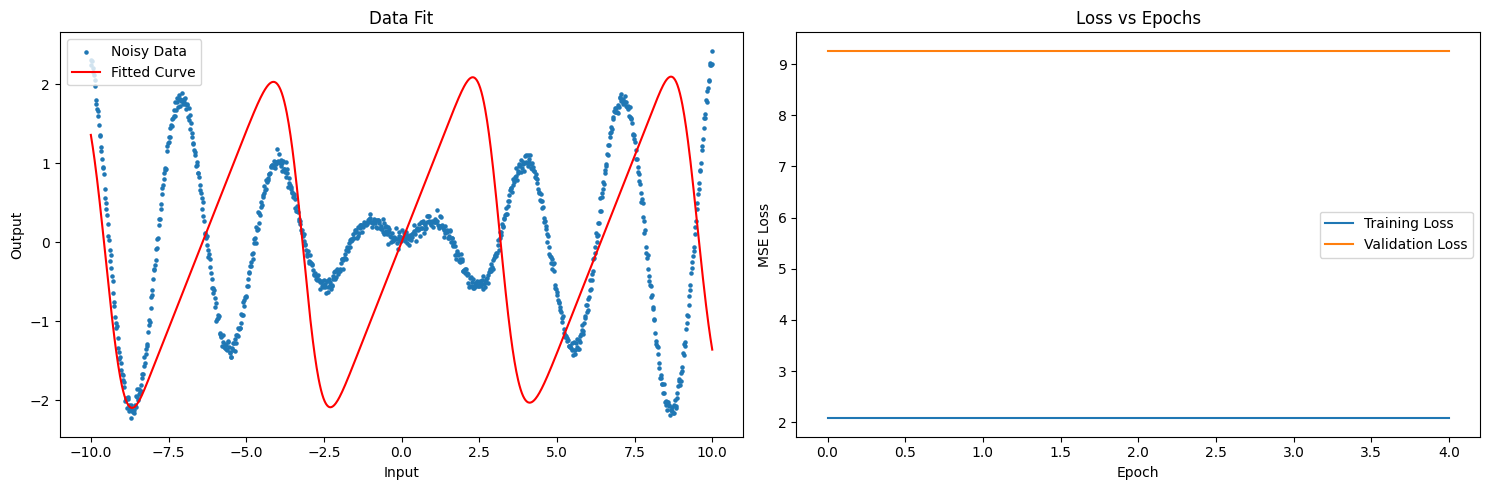

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()
Y_pred = M[0].predict(X_data, verbose = 0)
axes[0].scatter(X, Y_noisy, s=5, label='Noisy Data')
axes[0].plot(X, Y_pred, label='Fitted Curve', color='r')
#axes[0].plot(X, Y, label='True Curve', color='g')
axes[0].set_title('Data Fit')
axes[0].set_xlabel('Input')
axes[0].set_ylabel('Output')
axes[0].legend()

axes[1].plot(H[0].history['loss'], label='Training Loss')
axes[1].plot(H[0].history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss vs Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].legend()

plt.tight_layout()
plt.show()